In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

In [35]:
# Load JSON file
with open(r"data/intents.json", "r", encoding="utf-8") as file:
    data = json.load(file)

# Prepare a list to store rows
rows = []

# Extract each intent
for intent in data["intents"]:
    tag = intent["tag"]
    for pattern in intent["patterns"]:
        for response in intent["responses"]:
            rows.append([tag, pattern, response])

# Convert to DataFrame
data_1 = pd.DataFrame(rows, columns=["Tag", "Pattern", "Response"])

# Save to CSV
df.to_csv(r"data/intents.csv", index=False)

print("JSON successfully converted to CSV!")


JSON successfully converted to CSV!


In [36]:
data_1

,Tag,Pattern,Response
0,greeting,Hi,Hello there. Tell me how are you feeling today?
1,greeting,Hi,Hi there. What brings you here today?
2,greeting,Hi,Hi there. How are you feeling today?
3,greeting,Hi,Great to see you. How do you feel currently?
4,greeting,Hi,Hello there. Glad to see you're back. What's g...
...,...,...,...
656,fact-29,How do I know if I'm unwell?,"If your beliefs , thoughts , feelings or behav..."
657,fact-30,How can I maintain social connections? What if...,"A lot of people are alone right now, but we do..."
658,fact-31,What's the difference between anxiety and stress?,Stress and anxiety are often used interchangea...
659,fact-32,What's the difference between sadness and depr...,"Sadness is a normal reaction to a loss, disapp..."


In [37]:
data_1.drop(columns=['Tag'], inplace=True)

# Save the updated dataset
data_1.to_csv("data/intents_updated.csv", index=False)

print("Tag column removed successfully!")


Tag column removed successfully!


In [38]:
# Load CSV files
intents_df = pd.read_csv(r"data/intents_updated.csv")
train_df = pd.read_csv(r"data/train.csv")

In [39]:

# Display first few rows of each dataset
print("Intents CSV:")
print(intents_df.head())

print("\nTrain CSV:")
print(train_df.head())

Intents CSV:
  Pattern                                           Response
0      Hi    Hello there. Tell me how are you feeling today?
1      Hi              Hi there. What brings you here today?
2      Hi               Hi there. How are you feeling today?
3      Hi       Great to see you. How do you feel currently?
4      Hi  Hello there. Glad to see you're back. What's g...

Train CSV:
                                             Context  \
0  I'm going through some things with my feelings...   
1  I'm going through some things with my feelings...   
2  I'm going through some things with my feelings...   
3  I'm going through some things with my feelings...   
4  I'm going through some things with my feelings...   

                                            Response  
0  If everyone thinks you're worthless, then mayb...  
1  Hello, and thank you for your question and see...  
2  First thing I'd suggest is getting the sleep y...  
3  Therapy is essential for those that are feelin...

In [40]:
print(intents_df.shape)
print(train_df.shape)

(661, 2)
(3512, 2)


In [41]:
intents_df.columns

Index(['Pattern', 'Response'], dtype='object')

In [42]:
train_df.columns

Index(['Context', 'Response'], dtype='object')

In [43]:
# Check for missing values
print("Missing values in intents dataset:")
print(intents_df.isnull().sum())

print("\nMissing values in train dataset:")
print(train_df.isnull().sum())

# Fill missing values with empty strings
intents_df.fillna("", inplace=True)
train_df.fillna("", inplace=True)


Missing values in intents dataset:
Pattern     4
Response    0
dtype: int64

Missing values in train dataset:
Context     0
Response    4
dtype: int64


In [44]:
# Remove duplicates
intents_df.drop_duplicates(inplace=True)
train_df.drop_duplicates(inplace=True)

print("Duplicates removed!")


Duplicates removed!


In [45]:
intents_df.shape

(661, 2)

In [46]:
train_df.shape

(2752, 2)

In [47]:
import re

# Simple text preprocessing function
def preprocess_text_simple(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"[^\w\s]", " ", text)  # Remove punctuation
    text = re.sub(r"\s+", " ", text)  # Remove extra spaces
    return text.strip()  # Remove leading/trailing whitespaces

# Apply to both datasets
intents_df["Pattern"] = intents_df["Pattern"].apply(preprocess_text_simple)
intents_df["Response"] = intents_df["Response"].apply(preprocess_text_simple)
train_df["Context"] = train_df["Context"].apply(preprocess_text_simple)
train_df["Response"] = train_df["Response"].apply(preprocess_text_simple)


In [54]:
# Rename columns for merging
train_df.rename(columns={"Context": "Pattern"}, inplace=True)

# Merge on Pattern column
merged_df = pd.concat([intents_df, train_df], ignore_index=True)

# Save merged dataset
merged_df.to_csv("data/merged_dataset.csv", index=False)

print("Datasets merged successfully!")


Datasets merged successfully!


In [55]:
merged_df

,Pattern,Response
0,hi,hello there tell me how are you feeling today
1,hi,hi there what brings you here today
2,hi,hi there how are you feeling today
3,hi,great to see you how do you feel currently
4,hi,hello there glad to see you re back what s goi...
...,...,...
3408,after first meeting the client what is the pro...,hi this is an excellent question i think that ...
3409,my boyfriend is in recovery from drug addictio...,i m sorry you have tension between you and you...
3410,the birth mother attempted suicide several tim...,the true answer is no one can really say with ...
3411,i think adult life is making him depressed and...,how do you help yourself to believe you requir...


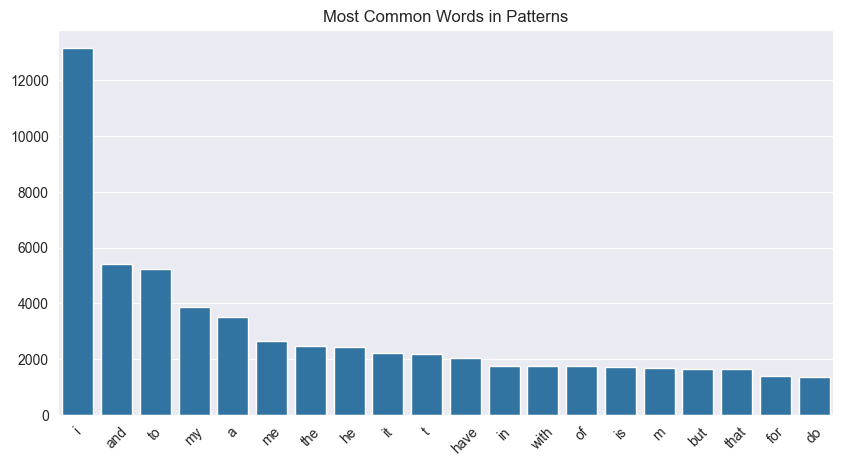

In [56]:
from collections import Counter
from wordcloud import WordCloud

# Concatenate all patterns
all_text = " ".join(merged_df["Pattern"])

# Get most common words
word_counts = Counter(all_text.split())
common_words = word_counts.most_common(20)

# Plot bar chart
plt.figure(figsize=(10, 5))
sns.barplot(x=[word[0] for word in common_words], y=[word[1] for word in common_words])
plt.xticks(rotation=45)
plt.title("Most Common Words in Patterns")
plt.show()


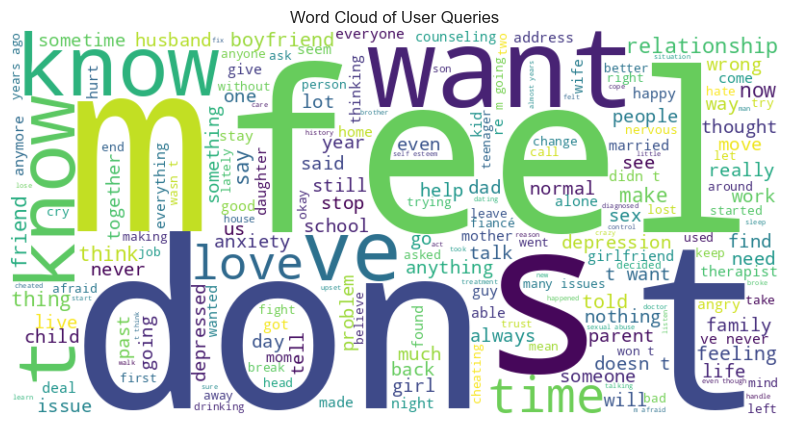

In [57]:
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of User Queries")
plt.show()


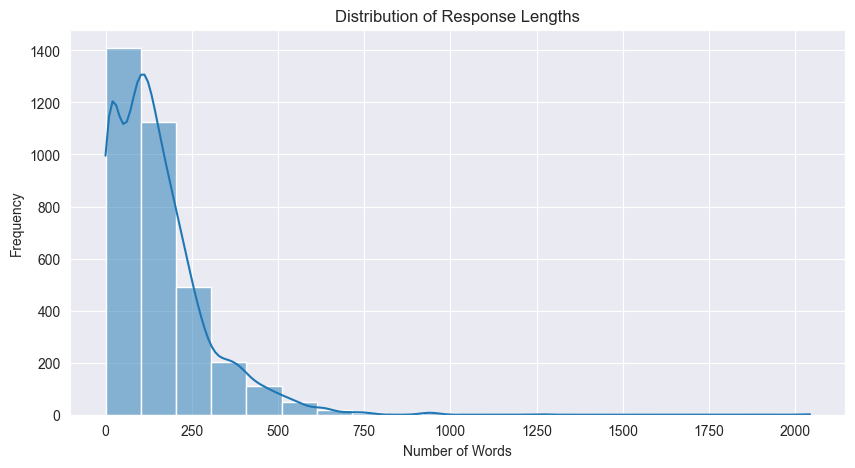

In [58]:
merged_df["Response_Length"] = merged_df["Response"].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 5))
sns.histplot(merged_df["Response_Length"], bins=20, kde=True)
plt.title("Distribution of Response Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()
